In [1]:
import os
import pickle

import numpy as np
import pandas as pd
from keras.src.applications.efficientnet import EfficientNetB0
from keras.src.applications.vgg16 import VGG16, preprocess_input
from keras.src.callbacks import EarlyStopping
from keras.src.utils import load_img, img_to_array
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.src.layers import Dense, Dropout, BatchNormalization
from keras import Sequential
from sklearn.model_selection import train_test_split


2024-11-25 16:53:19.853343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 16:53:19.868704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 16:53:19.872277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 16:53:19.882073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 16:53:20.773833: W tensorflow/compiler/tf2

## Construct dataset

In [2]:
augmented_folder = "./pictures_224_augmented"
data = []

population_ds = pd.read_csv('./population.csv')
population_ds['id'] = population_ds['id'].astype(str)

for nombre_archivo in os.listdir(augmented_folder):
    location = os.path.join(augmented_folder, nombre_archivo)
    id = nombre_archivo.replace("aug_","").split("_",1)[0]
    data.append({
        'location': location,
        'id': id
    })

images_ds = pd.DataFrame(data)
images_ds['id'] = images_ds['id'].astype(str)
images_ds['location'] = images_ds['location'].astype(str)
ds = pd.merge(images_ds, population_ds, on='id', how='left')
ds.drop('id', axis=1, inplace=True)
ds

,location,population
0,./pictures_224_augmented/aug_2034_2.png,0.000000
1,./pictures_224_augmented/aug_1909_1.png,377.630491
2,./pictures_224_augmented/aug_1579_5.png,2620.462209
3,./pictures_224_augmented/aug_1382_2.png,427.427092
4,./pictures_224_augmented/aug_1423_3.png,1625.360612
...,...,...
11630,./pictures_224_augmented/aug_2274_2.png,5.868478
11631,./pictures_224_augmented/aug_840_2.png,8.798968
11632,./pictures_224_augmented/aug_1733_1.png,9.971087
11633,./pictures_224_augmented/aug_1533_5.png,4557.015624


## Extract features

In [3]:
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
# base_model.trainable = True
image_paths = ds['location'].tolist()
batch_size = 8
features_list = []
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    batch_images = []
    for img_path in batch_paths:
        img = load_img(img_path, target_size=(224, 224))
        img_data = img_to_array(img)
        img_data = preprocess_input(img_data)
        batch_images.append(img_data)
    batch_images = np.array(batch_images)
    # Obtener las características para el lote actual
    features = base_model.predict(batch_images)
    features_list.extend(features)

I0000 00:00:1732564402.373330  688527 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732564402.421284  688527 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732564402.422622  688527 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732564402.425637  688527 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


I0000 00:00:1732564406.330705  688614 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

## Scale featrues

In [4]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(np.array(features_list))

In [13]:
scaled_features

array([[-0.24908681, -0.06109943, -0.29822785, ..., -0.25888273,
         0.24543418, -0.10536472],
       [-0.70125633,  1.3739557 , -0.75547147, ..., -0.25888273,
         0.5579571 , -0.7363805 ],
       [ 3.9098644 , -0.49853063,  5.4807224 , ..., -0.25888273,
         1.4585102 , -0.0966675 ],
       ...,
       [-0.70125633,  2.4259481 , -0.776021  , ..., -0.25888273,
        -0.20838366,  0.09953114],
       [-0.70125633,  2.0383236 ,  0.13278368, ...,  0.3367812 ,
         1.8804837 , -0.02109892],
       [-0.01180623, -0.7939119 ,  1.4923337 , ..., -0.25888273,
         0.0746671 , -0.5960641 ]], dtype=float32)

## Split test and train

In [5]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, ds["population"], test_size=0.2, random_state=42)

## Build model

In [6]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

/opt/projects/marvik/processing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,873 (2.01 MB)

 Trainable params: 526,849 (2.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Compile model

In [7]:
model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_absolute_error']
)

## Plot loss

Epoch 1/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 469.3318 - mean_absolute_error: 469.3318 - val_loss: 275.3270 - val_mean_absolute_error: 275.3270
Epoch 2/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 273.6367 - mean_absolute_error: 273.6367 - val_loss: 261.7255 - val_mean_absolute_error: 261.7255
Epoch 3/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 247.1803 - mean_absolute_error: 247.1803 - val_loss: 259.2789 - val_mean_absolute_error: 259.2789
Epoch 4/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 236.4334 - mean_absolute_error: 236.4334 - val_loss: 265.6834 - val_mean_absolute_error: 265.6834
Epoch 5/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 222.8984 - mean_absolute_error: 222.8984 - val_loss: 260.1827 - val_mean_absolute_error: 260.1827
Epoch 6/1000
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 223.1575 - mean_absolute_error: 223.1575 - val_loss: 251.7224 - val_mean_absolute_error: 251.7224
Epoch 7/1000
233/233 ━━━━━━━━━

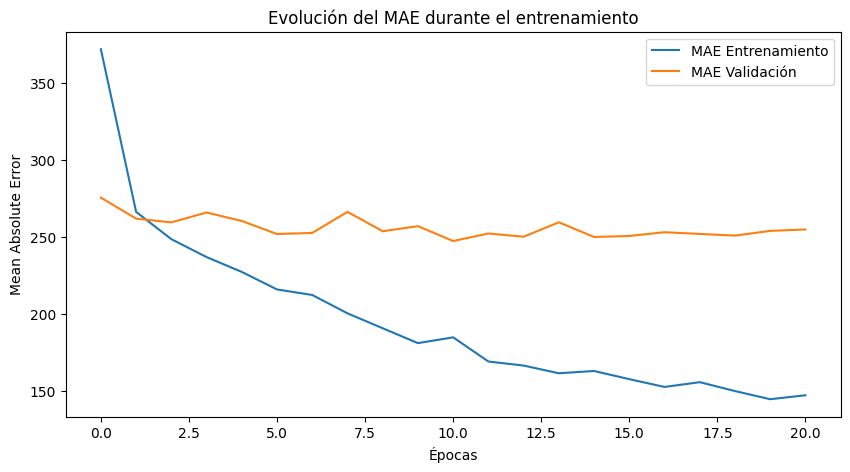

In [8]:

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, 
    y_train, 
    epochs=1000,
    batch_size=32, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[early_stop]
)

def plot_training(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['mean_absolute_error'], label='MAE Entrenamiento')
    plt.plot(history.history['val_mean_absolute_error'], label='MAE Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.title('Evolución del MAE durante el entrenamiento')
    plt.show()

plot_training(history)

In [9]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Error Cuadrático Medio (MSE) en Prueba: {test_loss:.4f}')
print(f'Error Absoluto Medio (MAE) en Prueba: {test_mae:.4f}')
y_pred = model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.4f}')
r2 = r2_score(y_test, y_pred)
print(f'R²: {r2:.4f}')

Error Cuadrático Medio (MSE) en Prueba: 233.3072
Error Absoluto Medio (MAE) en Prueba: 233.3072
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 244300.3781
R²: 0.7141


In [10]:
# residuals = y_test - y_pred
# sns.distplot(residuals, kde=True)
# plt.title('Distribución de Residuos')
# plt.show()

In [11]:
# from sklearn.model_selection import KFold
# 
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Export model

In [12]:
model.save('./modelo.keras')
with open('app/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)